In [ ]:
import torch
from models import SomnoNet_encoder, SomnoNet_decoder_vector
import numpy as np
from utils import net_param_k, trans_data, gen_showMap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn as nn

In [2]:
# Configuration file path
encoder_weights_path = "weights/voting_encoder_fold_0.pth"
decoder_weights_path = "weights/vector_decoder_fold_0.pth"  # same as 'Interpretability_vector_forward.ipynb'
data_w_path = "example_data/example_data_0.npy"
data_n1_path = "example_data/example_data_1.npy"
data_n2_path = "example_data/example_data_2.npy"
data_n3_path = "example_data/example_data_3.npy"

# Configuration other
device="cpu"
map_color="Blues"

In [ ]:
# Load model
encoder_dict = torch.load(encoder_weights_path, weights_only=True)
encoder_net = SomnoNet_encoder()
encoder_net.load_state_dict(encoder_dict,strict=False)
encoder_net = encoder_net.to(device)
encoder_net.eval()   

decoder_dict = torch.load(decoder_weights_path, weights_only=True)
decoder_net = SomnoNet_decoder_vector()
decoder_net.load_state_dict(decoder_dict,strict=False)
decoder_net = decoder_net.to(device)
decoder_net.eval()  

# Load data
data_w = np.load(data_w_path)
data_n1 = np.load(data_n1_path)
data_n2 = np.load(data_n2_path)
data_n3 = np.load(data_n3_path)

print('[parameters] ','(vector-based model) ', "Total parameters:", net_param_k(encoder_net)+net_param_k(decoder_net),"k (encoder:",net_param_k(encoder_net),"k, decoder:",net_param_k(decoder_net), "k)" )

[parameters]  (vector-based model)  Total parameters: 36.405 k (encoder: 36.24 k, decoder: 0.165 k)


In [4]:
def is_none(obj):
    return obj is None
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
        print(f"name={name}, grad={is_none(grad)}")
    return hook
criterion = nn.CrossEntropyLoss()
   
data_list = [data_w, data_n1, data_n2, data_n3]
show_data_list = []
decision_vector_list = []
decision_map_list = []
feature_avg_list = []
grad_feature_avg = []
grad_output = []
output_i_list = []
for data_idx in range(len(data_list)):
    # data_idx=0
    data_i = trans_data(data_list[data_idx], dim=4, torch_trans=True)
    show_data_list.append(data_i)
    feature_map_i = encoder_net(data_i)
    output_i, feature_avg = decoder_net(feature_map_i) 
    pred_i = torch.argmax(output_i,-1).reshape(-1)
    loss = criterion(output_i.squeeze(0), pred_i)
    output_i.register_hook(save_grad('output_i'))
    feature_avg.register_hook(save_grad('feature_avg'))
    loss.backward()
    feature_avg_list.append(feature_avg)
    grad_feature_avg.append(grads['feature_avg'][0])
    grad_output.append(grads['output_i'][0])
    output_i_list.append(output_i)
    decision_vector = -np.array(grads['feature_avg'][0].cpu())
    decision_map_i = np.mean(feature_map_i.detach().numpy()*decision_vector,-1)
    decision_vector_list.append(decision_vector)
    decision_map_list.append(decision_map_i.squeeze())

name=output_i, grad=False
name=feature_avg, grad=False
name=output_i, grad=False
name=feature_avg, grad=False
name=output_i, grad=False
name=feature_avg, grad=False
name=output_i, grad=False
name=feature_avg, grad=False


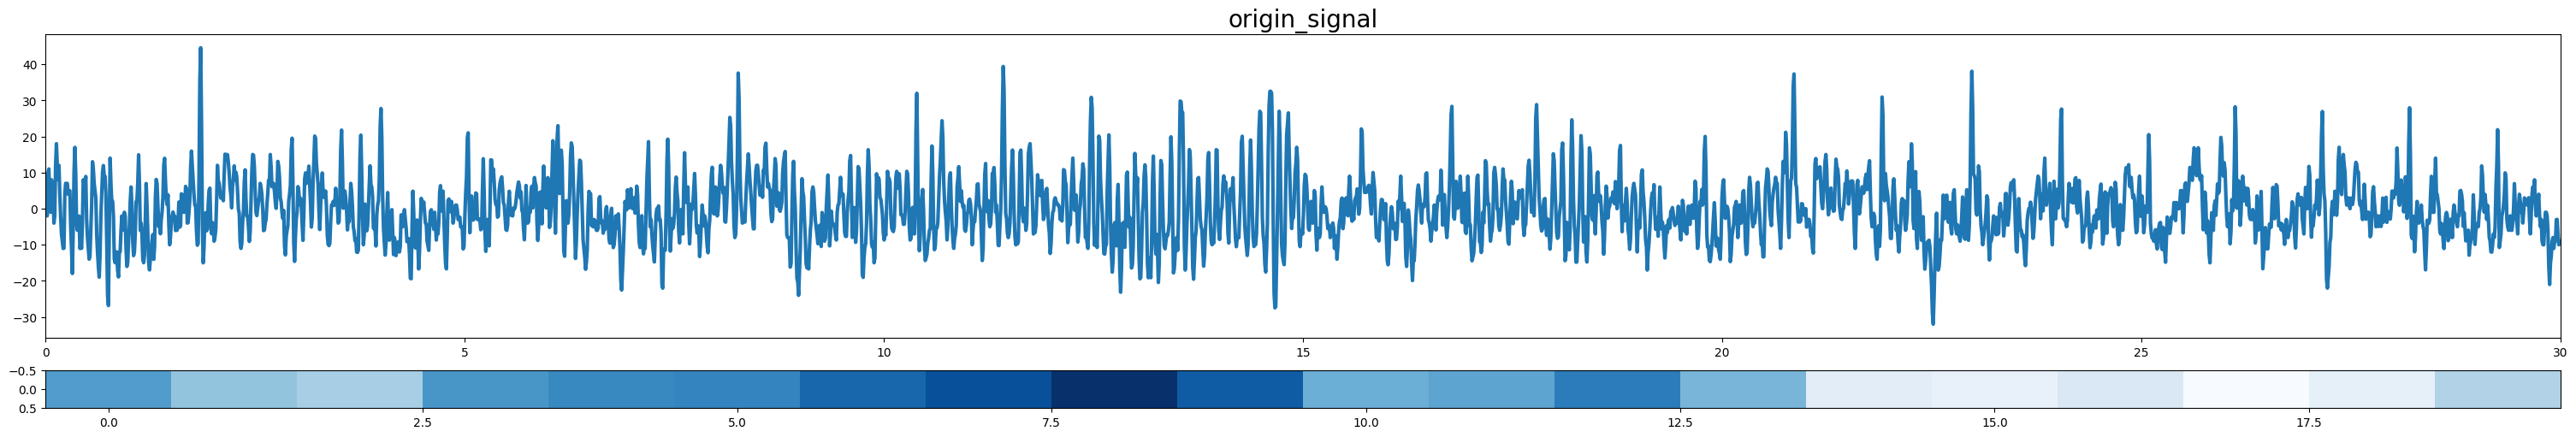

In [6]:
# show dicision map
show_idx = 0
cam_input = show_data_list[show_idx].squeeze().numpy()
decision_map = gen_showMap(decision_map_list[show_idx])
cam_input_t = np.linspace(0,30,3000)
fig = plt.figure(dpi=100, constrained_layout=True)
gs = GridSpec(9, 9, figure=fig)
ax1 = fig.add_subplot(gs[0:8, :])
plt.title('origin_signal',fontsize=20)
plt.plot(cam_input_t,cam_input,linewidth=3)
plt.xlim(cam_input_t[0],cam_input_t[-1])
ax2 = fig.add_subplot(gs[8, :])
plt.imshow(decision_map[np.newaxis,:], cmap=map_color, aspect="auto")
fig.set_size_inches(30, 5)